## Difference-in-Differences (DiD) Analysis

Having confirmed (or adjusted for) parallel pre-trends, we now estimate the **treatment effect** of the expulsion initiative using two levels of aggregation:
1. **Nationwide** (Swiss vs. Foreigners, aggregated 2009–2024)  
2. **Canton-panel** (26 cantons × 2 groups × years)

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.regressionplots import influence_plot

### 1. Nationwide DiD with Group & Year Fixed Effects

To control for average differences across groups and over time, we estimate:

$\text{crime\_rate}_{gt}
=
\beta\,(T_{g}\times P_{t})
\;+\;FE_{g}
\;+\;FE_{t}
\;+\;\varepsilon_{gt}.$
- This absorbs any group-specific level and common time shocks.
- We still interpret the $T\times P$ coefficient as the causal effect.

This regression is conducted on the nationwide dataset

In [31]:
#2) Nationwide aggregated DiD w fixed effects
df_agg = pd.read_excel('/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned.xlsx')
df_agg['T'] = (df_agg['group']=="Foreigner").astype(int)
df_agg['P'] = (df_agg['year']>=2017).astype(int)
df_agg['log_crime_rate'] = np.log(df_agg['crime_rate_per_100k'])

model = smf.ols("log_crime_rate ~ T:P + C(group) + C(year)", data=df_agg).fit()
print("Nationwide DiD (w/ Fixed Effects)")
print(model.summary())

Nationwide DiD (w/ Fixed Effects)
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     315.7
Date:                Mon, 26 May 2025   Prob (F-statistic):           3.27e-13
Time:                        23:23:34   Log-Likelihood:                 58.401
No. Observations:                  28   AIC:                            -84.80
Df Residuals:                      12   BIC:                            -63.49
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Inte

### 1. Canton-Panel DiD

$\text{crime\_rate}_{cgt}
= \beta\,(T_{g}\times P_{t})
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt}.$

In [32]:
# 3) Canton-panel DiD -----------------------------------------
df_ct = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")


good = []
for c in df_ct['canton'].unique():
    sub = df_ct[df_ct['canton']==c]
    good.append(c)
df_ct = df_ct[df_ct['canton'].isin(good)].copy()


# prepare DiD variables
df_ct['log_crime_rate'] = np.log(df_ct['crime_rate_per_100k'])
df_ct = df_ct[df_ct['log_crime_rate']>0]
df_ct['T'] = (df_ct['group']=="Foreigner").astype(int)
df_ct['P'] = (df_ct['year']>=2017).astype(int)
df_ct['T_P'] = df_ct['T'] * df_ct['P']
df_ct['t'] = df_ct['year'] - df_ct['year'].min()
df_ct['T_t'] = df_ct['T'] * df_ct['t']

# 3a) Simple canton panel DiD
mod1 = smf.ols("log_crime_rate ~ T_P + C(canton) + C(year) + C(group)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (simple)")
print(mod1.summary())


Canton-panel DiD (simple)
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     182.1
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.62e-19
Time:                        23:23:34   Log-Likelihood:                -278.76
No. Observations:                 556   AIC:                             633.5
Df Residuals:                     518   BIC:                             797.7
Df Model:                          37                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 15
  warnings.warn('covariance of constraints does not have full '


In [33]:
# Same model with obs>=6
counts = (
    df_ct
    .groupby('canton')['year']
    .agg(
        pre  = lambda yrs: (yrs < 2017).sum(),
        post = lambda yrs: (yrs >= 2017).sum()
    )
)

# 2) pick only cantons with at least 3 pre- and 3 post-treatment years
valid_cantons = counts[(counts['pre'] >= 3) & (counts['post'] >= 3)].index

df_filt = df_ct[df_ct['canton'].isin(valid_cantons)].copy()

# 3) re-run your DiD on that filtered panel
mod1_filt = smf.ols(
    "log_crime_rate ~ T_P + C(group) + C(canton) + C(year)",
    data=df_filt
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_filt['canton']}
)

print("\nCanton-panel DiD (with trend) — only cantons w/ ≥3 obs pre & post")
print(mod1_filt.summary())


Canton-panel DiD (with trend) — only cantons w/ ≥3 obs pre & post
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     172.6
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.55e-18
Time:                        23:23:34   Log-Likelihood:                -272.06
No. Observations:                 550   AIC:                             618.1
Df Residuals:                     513   BIC:                             777.6
Df Model:                          36                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 36, but rank is 15
  warnings.warn('covariance of constraints does not have full '


### 2. Canton-Panel DiD (parallelity hypothesis relaxed)

same model with $\theta$ variable to treat for parallelity

$\text{crime\_rate}_{cgt}
= \beta\,(T_{g}\times P_{t})
\;+\;\theta\,(T_{g}\times t)
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt},$

where $t$ is a **linear time index** (year–min(year)).

### 3. Canton-Specific DiD Regression Explanation

We estimate the following model:

$
\log\bigl(\text{crime\_rate}_{cgt}\bigr)
= \alpha 
\;+\;FE_{g}
\;+\;FE_{t}
\;+\;FE_{c}
\;+\;\sum_{c}\beta_{c}\,\Bigl(\mathbf{1}\{\text{canton}=c\}\times T_{g} \times P_{t}\Bigr)
\;+\;\varepsilon_{cgt},$
- **Outcome:** log of the crime rate for group $g$ (Swiss vs. foreigners), canton $c$, and year $t$.
- **$T_g \cdot P_t \cdot \mathbb{1}\{c = \text{canton}\}$:** canton-specific DiD effect, the treatment is interacted with post-period and canton identifiers, allowing the effect to vary by canton.

In [34]:
mod2 = smf.ols("log_crime_rate ~ T_P + T_t + C(group) + C(canton) + C(year)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (with trend)")
print(mod2.summary())


Canton-panel DiD (with trend)
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     4023.
Date:                Mon, 26 May 2025   Prob (F-statistic):           2.35e-34
Time:                        23:23:34   Log-Likelihood:                -278.74
No. Observations:                 556   AIC:                             635.5
Df Residuals:                     517   BIC:                             804.0
Df Model:                          38                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 16
  warnings.warn('covariance of constraints does not have full '


In [35]:
mod3 = smf.ols("log_crime_rate ~ C(group) + C(year) + C(canton) + C(canton):T_P", data=df_ct).fit()

print(mod3.summary())

['Aargau' 'Bern / Berne' 'Fribourg / Freiburg' 'Genève' 'Glarus'
 'Graubünden / Grigioni / Grischun' 'Jura' 'Luzern' 'Neuchâtel'
 'Nidwalden' 'Schaffhausen' 'Schwyz' 'Solothurn' 'St. Gallen' 'Thurgau'
 'Ticino' 'Valais / Wallis' 'Vaud' 'Zug' 'Zürich' 'Appenzell Ausserrhoden'
 'Obwalden' 'Uri']
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     31.83
Date:                Mon, 26 May 2025   Prob (F-statistic):          1.67e-133
Time:                        23:23:34   Log-Likelihood:                -266.60
No. Observations:                 556   AIC:                             653.2
Df Residuals:                     496   BIC:                             912.5
Df Model:                          59                                    

## Event study (final test)

$$
log(CR_{cgt})
= FE_{c} + FE_{t} + FE_{g}
+ \sum_{\substack{k=-5 \\ k\neq -1}}^{5}
    \beta_{k}\,\bigl[\mathbf{1}(t-2017 = k)\times D_{g}\bigr]
+ \varepsilon_{igt}
$$

In [36]:
df_ct = df_ct.copy()

# 1) Ensure year is int
df_ct['year'] = df_ct['year'].astype(int)

df_ct['treat'] = (df_ct['group'] == "Foreigner").astype(int)
print("Treated obs:", df_ct['treat'].sum(), "/", len(df_ct))

lead_cols = []
for k in range(-7, 7):
    if k == -1: 
        continue
    suffix = f"m{abs(k)}" if k < 0 else f"p{k}"
    name   = f"lead_{suffix}"
    df_ct[name] = ((df_ct['year'] - 2017) == k).astype(int) * df_ct['treat']
    print(f"{name}: {df_ct[name].sum()} treated obs")
    lead_cols.append(name)

# Event-study regression
formula = "log_crime_rate ~ " + " + ".join(lead_cols) + " + C(canton)+ C(group) + C(year)"
mod_es = smf.ols(formula, data=df_ct).fit(
    cov_type="cluster", cov_kwds={"groups": df_ct["canton"]})
print(mod_es.summary())

Treated obs: 278 / 556
lead_m7: 20 treated obs
lead_m6: 19 treated obs
lead_m5: 20 treated obs
lead_m4: 17 treated obs
lead_m3: 21 treated obs
lead_m2: 20 treated obs
lead_p0: 18 treated obs
lead_p1: 19 treated obs
lead_p2: 19 treated obs
lead_p3: 21 treated obs
lead_p4: 22 treated obs
lead_p5: 21 treated obs
lead_p6: 22 treated obs
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     94.79
Date:                Mon, 26 May 2025   Prob (F-statistic):           5.14e-17
Time:                        23:23:34   Log-Likelihood:                -275.73
No. Observations:                 556   AIC:                             651.5
Df Residuals:                     506   BIC:                             867.5
Df Model:                        

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 49, but rank is 22
  warnings.warn('covariance of constraints does not have full '


In [37]:
# error unbiased from outliers because of heteroskedasticity
mod2_hc3 = mod2.get_robustcov_results(cov_type='HC3')
print(mod2_hc3.summary())

                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     57.25
Date:                Mon, 26 May 2025   Prob (F-statistic):          9.59e-160
Time:                        23:23:34   Log-Likelihood:                -278.74
No. Observations:                 556   AIC:                             635.5
Df Residuals:                     517   BIC:                             804.0
Df Model:                          38                                         
Covariance Type:                  HC3                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

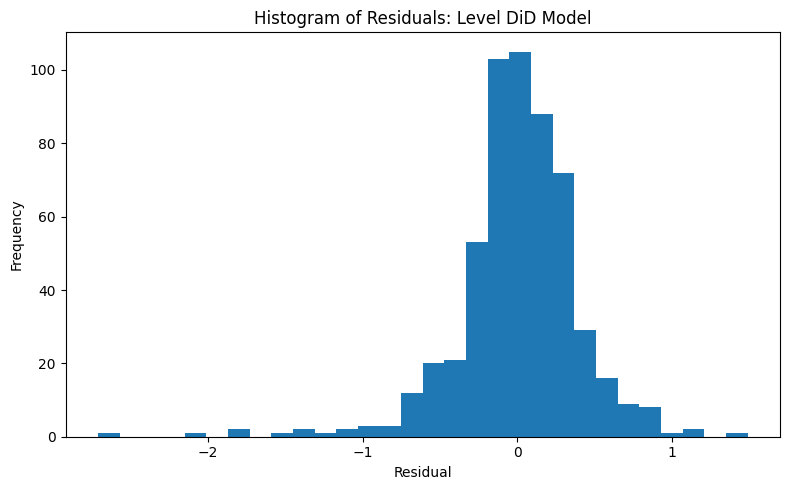

In [38]:
#Residual distribution
# Show a quick histogram of residuals for the level model—if they’re wildly skewed, that’s a strike for the log specification.
# -> residuals are normally distributed, most likely that linear specification is the correct one.

resid = mod2.resid

# Histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(resid, bins=30)
plt.title("Histogram of Residuals: Level DiD Model")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

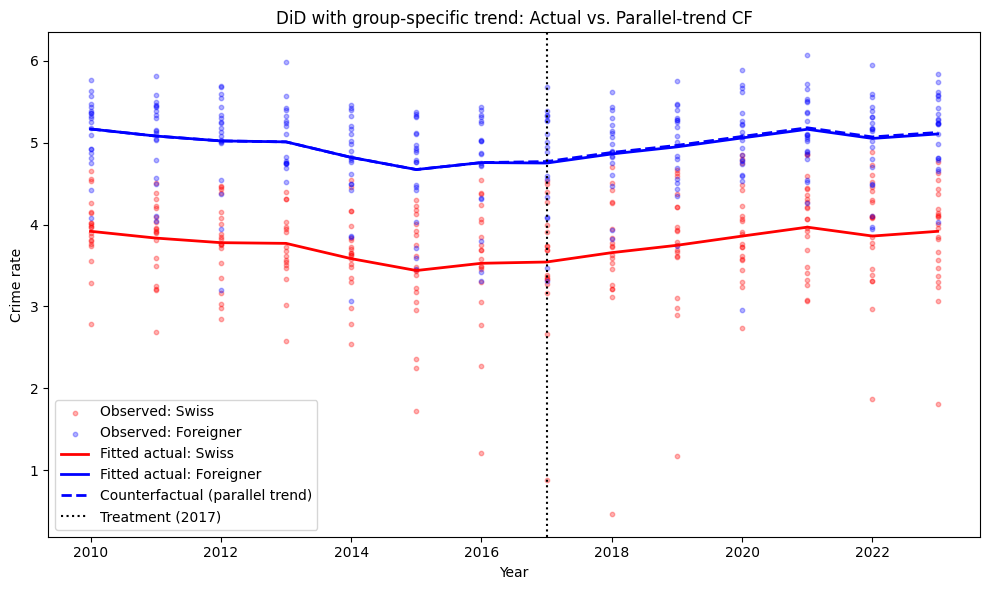

In [39]:
# Build a “counterfactual” dataset where Foreigner keeps its pre-treatment trend:
df_ct_cf = df_ct.copy()
# zero out the post dummy so the Foreigner×Post jump vanishes
df_ct_cf['T_P'] = 0

# keep the group‐specific trend term intact (so slope continues)
# T_t is just time × Foreigner, so it stays

# Predict both actual and counterfactual paths
df_ct['f_actual'] = mod2.predict(df_ct)
df_ct_cf['f_cf']    = mod2.predict(df_ct_cf)

# Aggregate to year × group means
agg = (
    df_ct
    .assign(f_cf=df_ct_cf['f_cf'])
    .groupby(['group','year'])
    .agg(obs_rate=('log_crime_rate','mean'),
         fit_actual=('f_actual','mean'),
         fit_cf    =('f_cf','mean'))
    .reset_index())

plt.figure(figsize=(10,6))

for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = df_ct[df_ct['group'] == grp]
    plt.scatter(sub['year'], sub['log_crime_rate'],
                color=color, alpha=0.3, s=10,
                label=f'Observed: {grp}')

for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = agg[agg['group']==grp]
    plt.plot(sub['year'], sub['fit_actual'], color=color, lw=2,
             label=f'Fitted actual: {grp}')
    if grp=='Foreigner':
        plt.plot(sub['year'], sub['fit_cf'], color=color, lw=2, ls='--',
                 label='Counterfactual (parallel trend)')

plt.axvline(2017, color='black', ls=':', lw=1.5, label='Treatment (2017)')

plt.xlabel('Year')
plt.ylabel('Crime rate')
plt.title('DiD with group‐specific trend: Actual vs. Parallel‐trend CF')
plt.legend()
plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/did_graph.png", dpi=300, bbox_inches='tight')  
plt.show()